In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os
import time

In [2]:
IMAGE_SIZE= 227
BATCH_SIZE= 20
CHANNELS= 3
EPOCHS= 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "color",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 54305 files belonging to 38 classes.


In [4]:
class_names = dataset.class_names
class_names
le = LabelEncoder()
encoded = le.fit_transform(class_names)
encoded = list(encoded)
# encoded_class = {x for x in class_names : y for y in encoded}
encoded_class = {}
for key in class_names:
    for value in encoded:
        encoded_class[key] = value
        encoded.remove(value)
        break
# le.fit_transform(class_names)

In [5]:
len(dataset)

2716

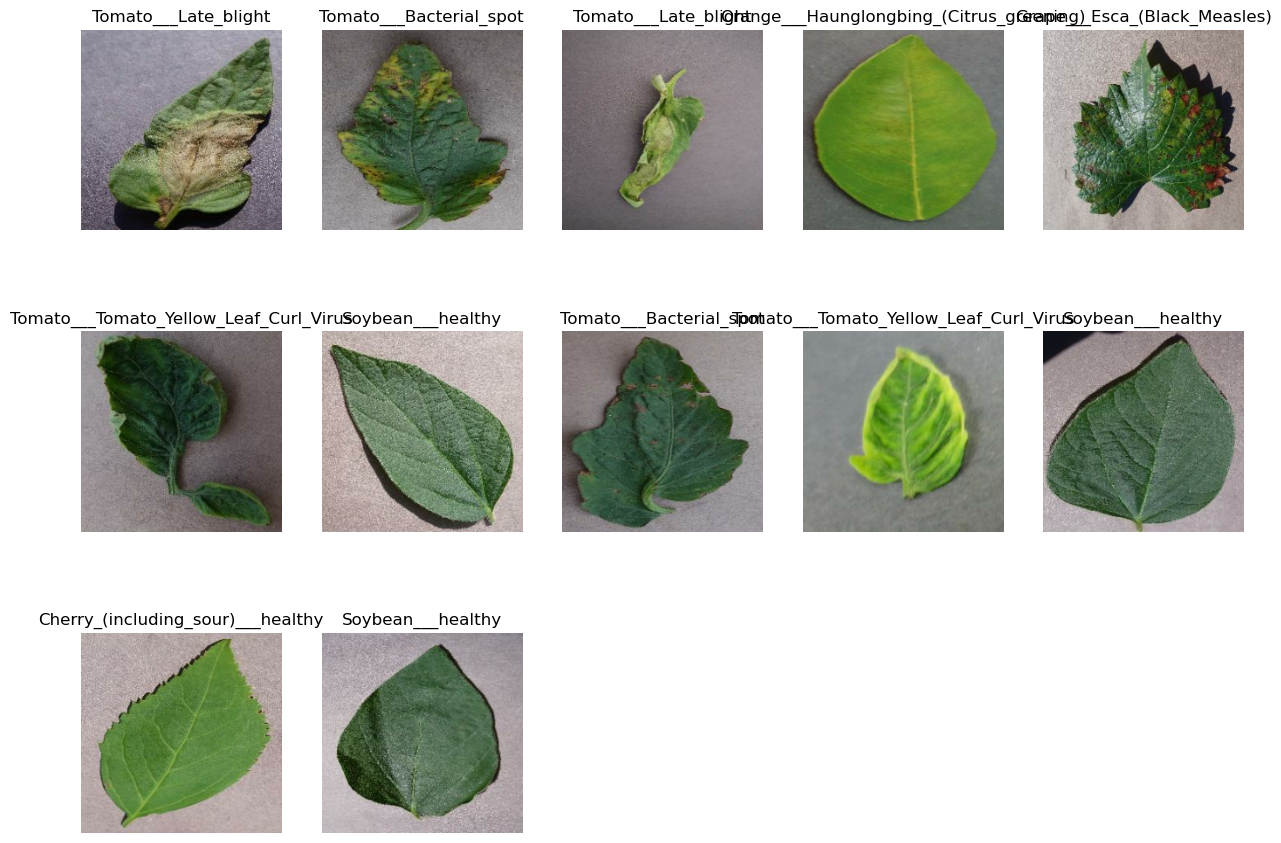

In [6]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in dataset.take(1):
       for i in range(12): 
        ax = plt.subplot(4,5, i+1)    
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# 80% ==> training
# 20% ==> 10% validation, 10% test
train_size = 0.8
len(dataset)*train_size

2172.8

In [8]:
train_ds = dataset.take(2173)
len(train_ds)


2173

In [9]:
test_ds = dataset.skip(2173)
len(test_ds)

543

In [10]:
val_size = 0.1
len(dataset)*val_size

271.6

In [11]:
val_ds = test_ds.take(272)
len(val_ds)

272

In [12]:
test_ds = dataset.skip(272)
len(test_ds)

2444

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size= len(ds)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
       
    train_size = int(train_split * ds_size)
        
    val_size = int(val_split * ds_size)
        
    train_ds = ds.take(train_size)
        
    val_ds = ds.skip(train_size).take(val_size)
        
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

2172

In [16]:
len(val_ds)

271

In [17]:
len(test_ds)

273

In [18]:
#optimiztion 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
def process_images(image_batch, label_batch):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image_batch = tf.image.per_image_standardization(image_batch)
    # Resize images from 32x32 to 277x277
    image_batch = tf.image.resize(image_batch, (227,227))
    return image_batch, label_batch

In [20]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(38, activation='softmax')
])

In [21]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

learning_rate = 0.005
decay_rate = learning_rate / 30
sgd = SGD(learning_rate=learning_rate, momentum=0.9, decay=decay_rate, nesterov=False)

model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [23]:
history= model.fit(train_ds,
                   epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
                   verbose=1,
                   validation_data=val_ds,
                   callbacks=[tensorboard_cb]
                  )

Epoch 1/30
2172/2172 [==============================] - 713s 227ms/step - loss: 2.1717 - accuracy: 0.5083 - val_loss: 1.5035 - val_accuracy: 0.5755
Epoch 2/30
2172/2172 [==============================] - 231s 106ms/step - loss: 0.8367 - accuracy: 0.7478 - val_loss: 0.5218 - val_accuracy: 0.8452
Epoch 3/30
2172/2172 [==============================] - 254s 117ms/step - loss: 0.5156 - accuracy: 0.8385 - val_loss: 0.3316 - val_accuracy: 0.8967
Epoch 4/30
2172/2172 [==============================] - 222s 102ms/step - loss: 0.3606 - accuracy: 0.8841 - val_loss: 0.4047 - val_accuracy: 0.8734
Epoch 5/30
2172/2172 [==============================] - 225s 104ms/step - loss: 0.2632 - accuracy: 0.9125 - val_loss: 0.2166 - val_accuracy: 0.9256
Epoch 6/30
2172/2172 [==============================] - 226s 104ms/step - loss: 0.2010 - accuracy: 0.9338 - val_loss: 0.1375 - val_accuracy: 0.9544
Epoch 7/30
2172/2172 [==============================] - 197s 91ms/step - loss: 0.1615 - accuracy: 0.9467 - val_l

In [24]:
model.evaluate(test_ds)

273/273 [==============================] - 98s 18ms/step - loss: 0.0308 - accuracy: 0.9918


[0.030842319130897522, 0.9917582273483276]

In [25]:
model_version = 29
model.save(f"../model29/{model_version}")

INFO:tensorflow:Assets written to: ../model29/29\assets


In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

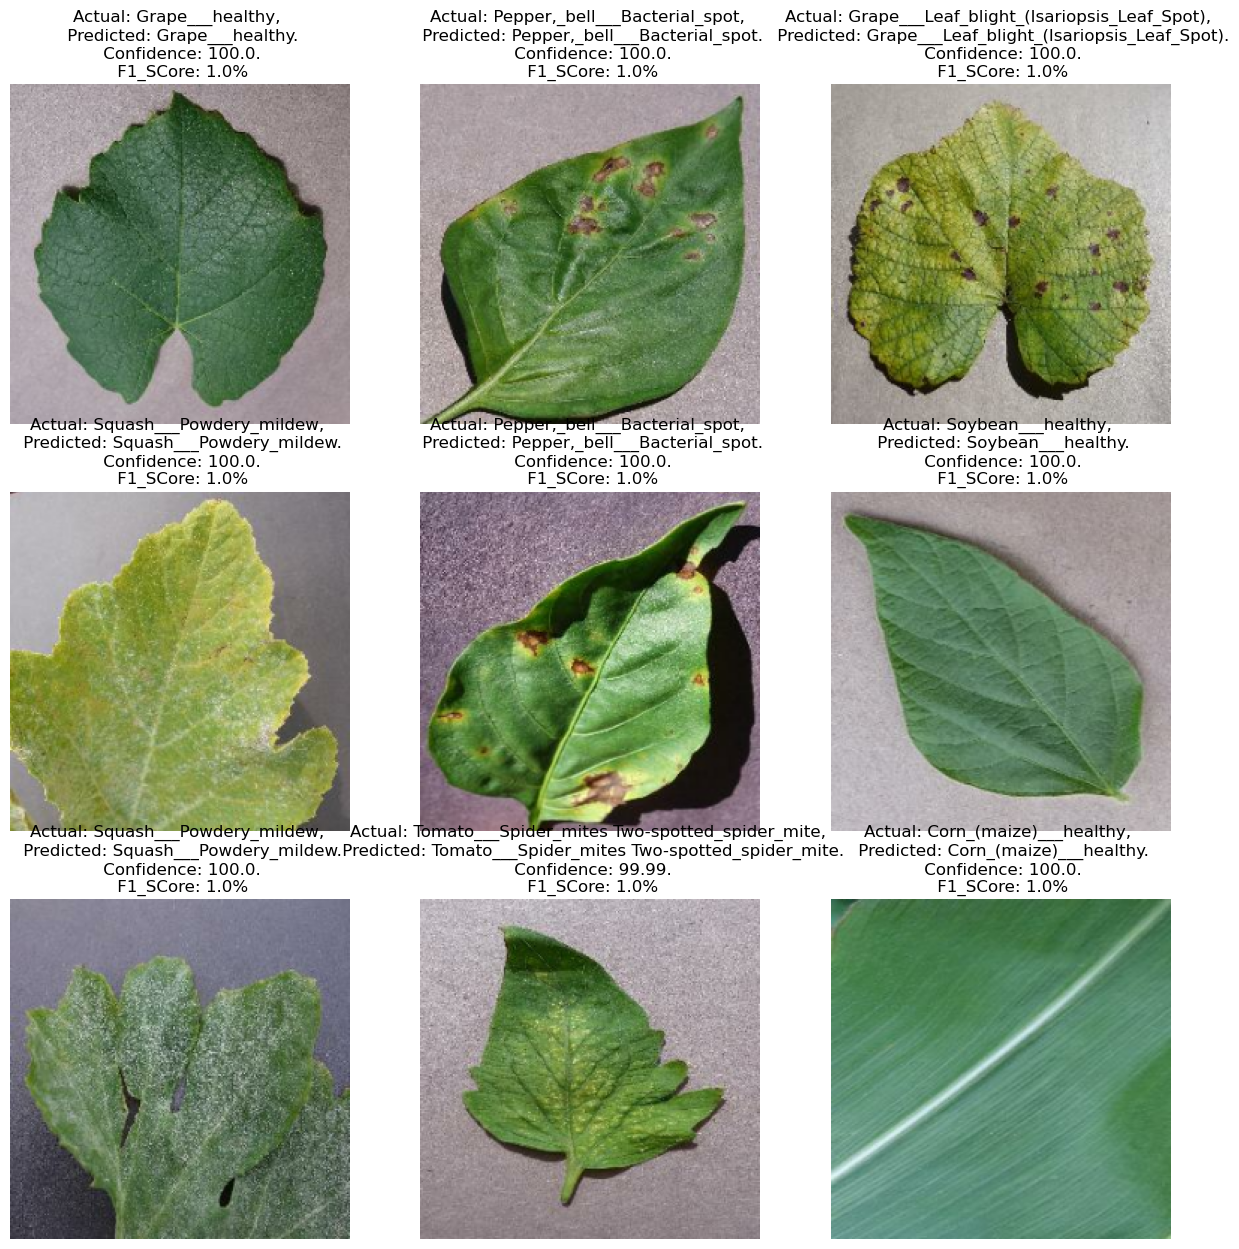

In [27]:
# 1st batch,9 images
import numpy as np
from sklearn.metrics import f1_score
over_all_actual_encoded = []
over_all_predicted_encoded = []

plt.figure(figsize=(15, 15))
for image_batch, label_batch in test_ds.take(10):

    for i in range(9):
        actualencoded = []
        predicted_encoded = []
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, image_batch[i].numpy())
        predicted_encoded.append(encoded_class.get(predicted_class))
#         print(predict(model, image_batch[i].numpy()))
        actual_class = class_names[label_batch[i]]
        actualencoded.append(encoded_class.get(actual_class))
        over_all_actual_encoded.append(encoded_class.get(actual_class))
        over_all_predicted_encoded.append(encoded_class.get(predicted_class))
        f1 = f1_score(actualencoded,predicted_encoded,average = 'micro')
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}.\n F1_SCore: {f1}%")
        
        plt.axis("off")

In [28]:
f1_score(over_all_actual_encoded,over_all_predicted_encoded,average = 'micro')

1.0

In [29]:
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
save_model(model, "model_ALex_color_V3_80_20.h5")